# Pix2Pix

- Based on: https://arxiv.org/pdf/1611.07004.pdf
- Possible upgrade to cloud
- datasets from http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/

In [1]:
import os
import time
import torch
import imageio
import itertools
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from tqdm.auto import tqdm

## Architecture

### Generator
There are two generator architectures tested in the paper:
- encoder-decoder
- U-net
Where U-net differs from encoder-decoder only by additional skip connections from $i$th layer to $(n-i)$th.

#### Key features
- all convolutional (no fully-connected layers)
- encoder has convolutions that downsample by a factor of 2
- decoder has transposed convolutions that upsample by a factor of 2
- filter=4, stride=2
- uses L1 regularization
- *doesn't* use noise as its input, only dropout **at both training and test time**

"Past conditional GANs (...)
provided Gaussian noise $z$ as an input to the generator, in
addition to $x$ (...). In initial experiments, we did not
find this strategy effective – the generator simply learned
to ignore the noise (...). Instead, **for our final models, we provide noise
only in the form of dropout**, applied on several layers of our
generator **at both training and test time**."

#### Encoder-Decoder

In [ ]:
class EncoderDecoderGenerator(torch.nn.Module):
    def __init__(self, optim, lambd=100, **kwargs):
        super(EncoderDecoderGenerator, self).__init__()

        # encoder
        # C64-C128-C256-C512-C512-C512-C512-C512
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2), # no batch norm in the first layer

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, 4, stride=2, padding=1),
            # nn.BatchNorm2d(512), # no batch norm in bottleneck layer
            nn.LeakyReLU(0.2)
        )

        # decoder
        # CD512-CD512-CD512-C512-C256-C128-C64
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5),
            nn.ReLU(),
        
            nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
       
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )
        
        self.optim = optim(self.parameters(), **kwargs)
    
        for layer in self.encoder:
            if type(layer) != nn.LeakyReLU:
                torch.nn.init.normal_(layer.weight, 0, 0.02)
        for layer in self.decoder:
            if type(layer) not in [nn.ReLU, nn.Dropout, nn.Tanh]:
                torch.nn.init.normal_(layer.weight, 0, 0.02)
        
        self.l1 = torch.nn.L1Loss()
        self.lambd = lambd

    def forward(self, y):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def loss(self, dis, y, target):
        x = self(y)
        p = dis(x, y)
        return -torch.mean(torch.log(p)) + self.lambd * self.l1(p, target)

    def update(self, dis, y, device="cpu"):
        self.optim.zero_grad()
        loss = self.loss(dis, y, torch.ones(y.shape[0], 1).to(device)) #dis.loss(p, torch.ones(y.shape[0], 1)) + self.l1(p, torch.)
        loss.backward()
        self.optim.step()
        return loss

#### U-Net

In [26]:
class UNetGenerator(torch.nn.Module):
    def __init__(self, optim, lambd=100, **kwargs):
        super(UNetGenerator, self).__init__()

        # encoder
        # C64-C128-C256-C512-C512-C512-C512-C512
        self.en_1 = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2) # no batch norm in the first layer
        )
        self.en_2 = nn.Sequential(
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        self.en_3 = nn.Sequential(
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        self.en_4 = nn.Sequential(
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )
        self.en_5 = nn.Sequential(
            nn.Conv2d(512, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )
        self.en_6 = nn.Sequential(
            nn.Conv2d(512, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )
        self.en_7 = nn.Sequential(
            nn.Conv2d(512, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )
        self.en_8 = nn.Sequential(
            nn.Conv2d(512, 512, 4, stride=2, padding=1),
            # nn.BatchNorm2d(512), # no batch norm in bottleneck layer
            nn.LeakyReLU(0.2)
        )

        # decoder
        # CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128 
        # For some reason there is one more layer in the U-net decoder in the paper
        # which causes (including last convolution with Tanh) to output 512x512 images
        # instead of 256x256
        # hence, I removed (for now) one C1024
        self.de_1 = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5),
            nn.ReLU()
        )
        self.de_2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 1024, 4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.Dropout(0.5),
            nn.ReLU()
        )
        self.de_3 = nn.Sequential(
            nn.ConvTranspose2d(1536, 1024, 4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.Dropout(0.5),
            nn.ReLU()
        )
        self.de_4 = nn.Sequential(
            nn.ConvTranspose2d(1536, 1024, 4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )
        self.de_5 = nn.Sequential(
            nn.ConvTranspose2d(1536, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.de_6 = nn.Sequential(
            nn.ConvTranspose2d(768, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.de_7 = nn.Sequential(
            nn.ConvTranspose2d(384, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.de_8 = nn.Sequential(
            nn.ConvTranspose2d(192, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )
        self.optim = optim(self.parameters(), **kwargs)
    
        for block in [self.en_1, self.en_2, self.en_3, self.en_4, self.en_5, self.en_6, self.en_7, self.en_8]:
            for layer in block:
                if type(layer) != nn.LeakyReLU:
                    torch.nn.init.normal_(layer.weight, 0, 0.02)
        for block in [self.de_1, self.de_2, self.de_3, self.de_4, self.de_5, self.de_6, self.de_7, self.de_8]:
            for layer in block:
                if type(layer) not in [nn.ReLU, nn.Dropout, nn.Tanh]:
                    torch.nn.init.normal_(layer.weight, 0, 0.02)
        
        self.l1 = torch.nn.L1Loss()
        self.lambd = lambd

    def forward(self, y):
        x1 = self.en_1(y)
        x2 = self.en_2(x1)
        x3 = self.en_3(x2)
        x4 = self.en_4(x3)
        x5 = self.en_5(x4)
        x6 = self.en_6(x5)
        x7 = self.en_7(x6)
        x8 = self.en_8(x7)

        z = self.de_1(x8)
        z = self.de_2(torch.cat((z, x7), dim=1))
        z = self.de_3(torch.cat((z, x6), dim=1))
        z = self.de_4(torch.cat((z, x5), dim=1))
        z = self.de_5(torch.cat((z, x4), dim=1))
        z = self.de_6(torch.cat((z, x3), dim=1))
        z = self.de_7(torch.cat((z, x2), dim=1))
        z = self.de_8(torch.cat((z, x1), dim=1))
        return z
    
    def loss(self, dis, y, target):
        x = self(y)
        p = dis(x, y)
        return -torch.mean(torch.log(p)) + self.lambd * self.l1(p, target)

    def update(self, dis, y, device="cpu"):
        self.optim.zero_grad()
        loss = self.loss(dis, y, torch.ones(y.shape[0], 1).to(device)) #dis.loss(p, torch.ones(y.shape[0], 1)) + self.l1(p, torch.)
        loss.backward()
        self.optim.step()
        return loss

### Discriminator

#### Key features
- "PatchGAN", evaluates all NxN patches of input
- outputs matrix of probabilities
- end output is an average of that matrix
- convolutionally implemented sliding window

In [35]:
class Pix2PixDiscriminator(torch.nn.Module):
    def __init__(self, optim, criterion, **kwargs):
        super(Pix2PixDiscriminator, self).__init__()
        self.criterion = criterion
        
        # 70x70
        # C64-C128-C256-C512
        
        # 6 input channels because mask is concatenated (no idea if this is right,
        # just an idea since there is nothing about what to do with conditional input in the paper)
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 1, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

        self.optim = optim(self.parameters(), **kwargs)

        for layer in self.model:
            if type(layer) not in [nn.LeakyReLU, nn.Sigmoid]:
                nn.init.normal_(layer.weight, 0, 0.02)

    def forward(self, x, y):
        # TODO: WHAT DO I DO WITH y?
        x = torch.cat((x, y), dim=1) # random idea
        x = self.model(x)
        x = torch.mean(x, dim=(2,3))
        return x

    def loss(self, x, y):
        return self.criterion(x, y)

    def update(self, true_sample, gen_sample, y, device="cpu"):
        self.optim.zero_grad()

        # division by 2 to slow down D
        true_loss = self.loss(self(true_sample, y), torch.ones(true_sample.shape[0], 1).to(device)) / 2
        prob = self(gen_sample, y)
        false_loss = self.loss(prob, torch.zeros(gen_sample.shape[0], 1).to(device)) / 2

        true_loss.backward()
        false_loss.backward()
        self.optim.step()
        return true_loss + false_loss, prob

## Helper functions

In [4]:
def gen_save_examples(path, gen, cond_gen, period, name_format, **kwargs):
    def save_examples(epoch, batch):
        if batch % period != 0:
            return
        examples = gen(next(cond_gen))
        if not os.path.isdir(path):
            os.mkdir(path)
        torchvision.utils.save_image((std*examples + mean).detach(),
                                     fp=os.path.join(path, name_format.format(epoch=epoch, batch=batch)), **kwargs)
    return save_examples

def gen_save_model(path, gen, dis, batch_size, period, name_format):
    def save_model(epoch, batch, stats):
        if batch % period != 0:
            return
        if not os.path.isdir(path):
            os.mkdir(path)
        fullname = os.path.join(path, name_format.format(epoch=epoch, batch=batch))
        torch.save({
            "epoch": epoch,
            "batch_size": batch_size,
            "dis_state_dict": dis.state_dict(),
            "dis_optim_state_dict": dis.optim.state_dict(),
            "gen_state_dict": gen.state_dict(),
            "gen_optim_state_dict": gen.optim.state_dict(),
            "stats": stats
        }, fullname)
    return save_model

def gen_get_masks(batch_size, device="cpu"):
    test_loader = torch.utils.data.DataLoader(facades_test, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
    def get_masks():
        for imgs, masks in itertools.cycle(test_loader):
            imgs, masks = imgs.to(device), masks.to(device)
            yield masks
    return get_masks()

def load_model(path, gen, dis):
    state = torch.load(path)
    gen.load_state_dict(state["gen_state_dict"])
    gen.optim.load_state_dict(state["gen_optim_state_dict"])
    dis.load_state_dict(state["dis_state_dict"])
    dis.optim.load_state_dict(state["dis_optim_state_dict"])
    return state["epoch"], state["batch_size"], state.get("stats", {"dis": { "loss": [], "prob": []}, "gen": {"loss": []}})

def show_stats(stats):
    """Plots loss and simple average."""
    fig, (p1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

    p1.plot(stats["gen"]["loss"], color="blue", label="generator train loss")
    p1.plot(stats["dis"]["loss"], color="green", label="discriminator train loss")
    p1.set_xlabel("epochs")
    p1.set_ylabel("loss")
    p1.legend()

    plt.yscale("log")
    plt.show()

## Training loop

In [42]:
def train(gen, dis, loader, epochs, device="cpu", fw_snapshot=None, model_snapshot=None, k=1, k2=1):
    print(f"Using device: {device}")
    stats = {'dis': {
        'loss': [],
        'prob': []
    }, 'gen': {
        'loss': [] 
    }}
    gen.train()
    dis.train()

    try:
        for i in range(epochs):
            pbar = tqdm(enumerate(iter(loader)), total=len(loader))
            pbar.set_description("epoch %s/%s" % (i, epochs))
            dloss, pr = 0, 0
            gloss = 0
            for j, (images, masks) in pbar:
                images, masks = images.to(device), masks.to(device)
                batch_prob, batch_dloss, batch_gloss = 0, 0, 0
                for _ in range(k):
                    l, p = dis.update(images, gen(masks).to(device), masks, device=device)
                    batch_dloss += l
                    batch_prob += p
                for _ in range(k2):
                    batch_gloss += gen.update(dis, masks, device=device)
                batch_prob = float(torch.mean(batch_prob) / k)
                batch_dloss = float(torch.mean(batch_dloss) / k)
                batch_gloss = float(torch.mean(batch_gloss) / k2)
                dloss += batch_dloss
                gloss += batch_gloss
                pr += batch_prob
                pbar.write("D(G(z)): %.2f, generator loss: %.2f, discriminator loss: %.2f" % 
                           (float(batch_prob), float(batch_gloss), float(batch_dloss)), end="\r")
                if fw_snapshot is not None:
                    fw_snapshot(i, j)
                if model_snapshot is not None:
                    model_snapshot(i, j, stats)
            stats['gen']['loss'].append(gloss / len(loader))
            stats['dis']['prob'].append(pr / len(loader))
            stats['dis']['loss'].append(dloss / len(loader))
    except KeyboardInterrupt:
        if model_snapshot is not None:
            model_snapshot("%s_KeyboardInterrupt" % epochs, 0, stats)
    return stats

## Experiment 1: Facades

### Load the dataset

In [7]:
from facades_loader import Facades

class RandomJitter:
    def __init__(self, scale, targetscale, p=0.5):
        self.p = p
        self.rescale = transforms.Resize(scale)
        self.crop = transforms.RandomCrop(targetscale)
    
    def __call__(self, img):
        if torch.rand(1) < self.p:
            return self.crop(self.rescale(img))
        return img

std, mean = 0.5, 0.5

torch.manual_seed(777)
facades_train = Facades(root="datasets", folder="train", download=True,
                        transform=transforms.Compose([transforms.ToTensor(),
                                                      RandomJitter((286,286), (256,256), 0.5),
                                                      transforms.RandomHorizontalFlip(0.5),
                                                      transforms.Normalize(mean, std)]))
facades_test = Facades(root="datasets", folder="test", download=False,
                        transform=transforms.Compose([transforms.ToTensor(),
                                                      transforms.Normalize(mean, std)]))

### Dataset preview

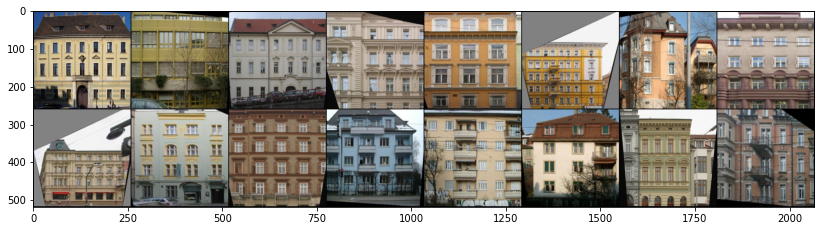

In [8]:
testloader = torch.utils.data.DataLoader(facades_train, batch_size=16, shuffle=True, num_workers=0)
testiter = iter(testloader)
img, masks = testiter.next()

fig, ax = plt.subplots(figsize=(14,14))
ax.imshow(torchvision.utils.make_grid(std*img + mean).detach().numpy().transpose(1, 2, 0), cmap="gray")

try:
    print(dis(img, masks).T)
except NameError:
    pass

### Training

In [36]:
BATCH_SIZE = 1
LR = 0.0002
BETAS = (0.5, 0.999)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#gen = Pix2PixGenerator(optim=torch.optim.Adam, lr=LR, betas=BETAS).to(DEVICE)
gen = UNetGenerator(optim=torch.optim.Adam, lr=LR, betas=BETAS).to(DEVICE)
dis = Pix2PixDiscriminator(optim=torch.optim.Adam, criterion=torch.nn.BCELoss(), lr=LR, betas=BETAS).to(DEVICE)


In [49]:
EPOCHS=20
TIME = time.strftime("%Y-%m-%d_%H-%M", time.localtime())

# fw_snapshot = gen_save_examples("images/%s" % TIME, gen, cond_gen=gen_get_masks(16),
                                # period=50, name_format="{epoch}_{batch}.png",
                                # nrow=8, padding=0)
# model_snapshot = gen_save_model("models/", gen, dis, BATCH_SIZE, period=200,
                                # name_format="facades_%s_{epoch}_{batch}" % TIME)

dataloader = torch.utils.data.DataLoader(facades_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
stats = train(gen, dis, dataloader, epochs=EPOCHS, device=DEVICE) #, fw_snapshot=fw_snapshot, model_snapshot=model_snapshot)

Using device: cuda:0


### Loss plot

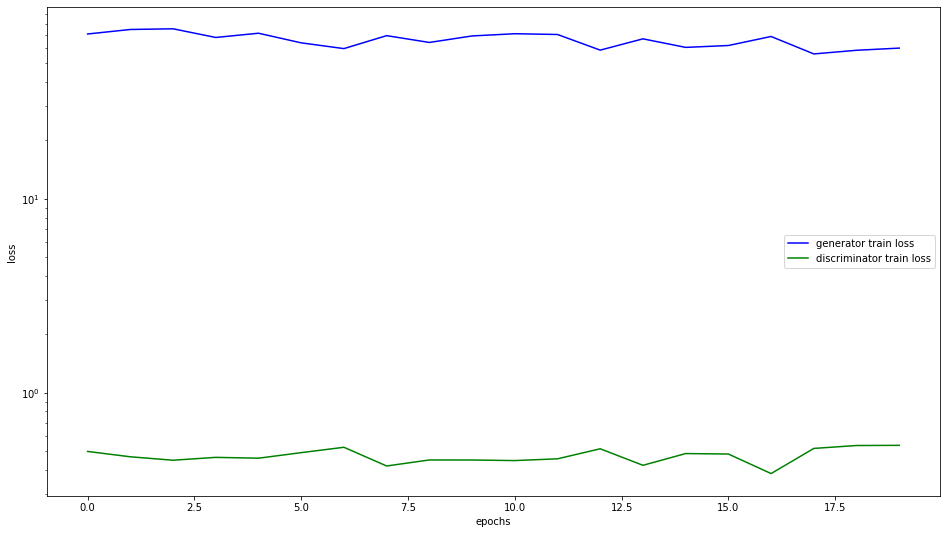

In [50]:
show_stats(stats)

### Save

In [ ]:
save_model("models/", "facades_%s" % TIME, gen, dis, stats, EPOCHS, BATCH_SIZE)

In [ ]:
with imageio.get_writer("images/%s/result_test.gif" % TIME, mode='I', duration=0.1) as writer:
    for i in range(5):
        step = i * 5 +  1
        writer._duration = 0.1 * i + 0.1
        for filename in ["images/%s/%d_%d.png" % (TIME, i, j) for j in range(0, len(dataloader), step)]:
            image = imageio.imread(filename)
            writer.append_data(image)

### Load

In [ ]:
gen = Pix2PixGenerator(optim=torch.optim.Adam)
dis = Pix2PixDiscriminator(optim=torch.optim.Adam, criterion=torch.nn.BCELoss())
EPOCHS, BATCH_SIZE, stats = load_model("models/facades_2020-12-25_23-30_KeyboardInterrupt", gen, dis)

### Generator preview

tensor([[0.5550, 0.5968, 0.6135, 0.5318, 0.5247, 0.5384, 0.4962, 0.6309, 0.5593,
         0.5140, 0.5848, 0.4776, 0.5363, 0.5610, 0.6278, 0.5587]],
       device='cuda:0', grad_fn=<PermuteBackward>)


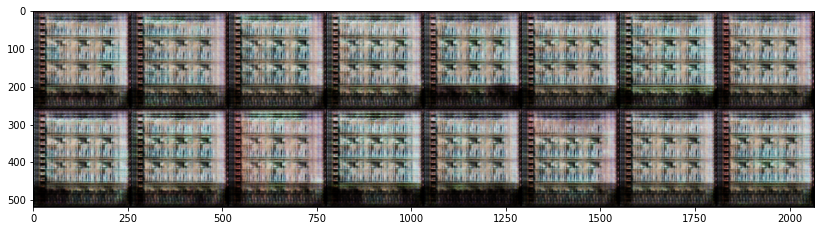

In [51]:
imgs, masks = testiter.next()
imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
test = gen(masks)

fig, ax = plt.subplots(figsize=(14,14))
ax.imshow(torchvision.utils.make_grid(std*test.to("cpu") + mean).detach().numpy().transpose(1, 2, 0), cmap="gray")

print(dis(test, masks).T)